<a href="https://colab.research.google.com/github/KWANGJAEIM/AI_project/blob/main/%EC%83%81%EC%B6%94%EC%83%9D%EC%9C%A1(ave%2C%20%EA%B4%91%EB%88%84%EC%A0%81).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd "./drive/My Drive/Data/lettuce"

/content/drive/My Drive/Data/lettuce


In [7]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [8]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math 
# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import lightgbm as lgb

# Setting Random Seed
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#########################################################################################################
DATA_DIR = 'lettuce/'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

TEST_OUTPUT = 'answer_example.csv'

#########################################################################################################
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

categoricals = []
# FEATURES =['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
#            '시간당백색광량',  '시간당적색광량', '시간당청색광량',
#        '시간당총광량', ]
FEATURES = ['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '일간누적백색광량',  '일간누적적색광량', '일간누적청색광량',
       '일간누적총광량', ]      
FEATURES_sum= ['DAT', 'obs_time', 
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량' ]      
FEATURES2 =['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
FEATURES3 = [ 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Python: %s'%sys.version)



Numpy: 1.21.6
Pandas: 1.3.5
LightGBM: 3.3.2
Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [ ]:
df = pd.read_csv("./train_input/CASE_02.csv")[FEATURES].ffill().bfill()
# df['obs_time']

# def get_time(x,numbers):
#     x['DAT']= x['DAT'].map(lambda x: x+1)
#     # x['DAT']= x['DAT'].map(lambda x: str(x))
#     x['DAT']= x['DAT'].map(lambda x: '0'+str(x) if x<10 else str(x))
#     x['DAT']=x['DAT'] +pd.to_datetime('2000-01-01')
#     x['obs_time'] = x['obs_time'].map(lambda x: '23:59' if x.split(':')[0]+':'+ x.split(':')[1] =='2400' else x)
#     x['시간'] = x['DAT'].map(lambda x: x)  +x['obs_time']
#     x['시간'] = x['시간'].map(lambda x: x.split(':')[0]+x.split(':')[1])
    
#     x['시간'] = x['시간'].map(lambda x:pd.to_datetime('2000-01-01'+' ' +x))
#     x['시간'] = pd.to_datetime(x['시간'],format= '%d%H%M')
#     x.drop(columns = ['DAT','obs_time'])
#     return x
# get_time(df)

# x['시간'] = x['시간'].map(lambda x: f'20{numbers}01'+x)
# x['DAT'] = pd.to_datetime(x['DAT'], format='%d')
# x['obs_time']=pd.to_datetime(x['obs_time'], format='%H:%M')
# origin = f'20{numbers}-01-01'

In [12]:
# x_position ="./train_input/CASE_02.csv"
# numbers = re.sub(r'[^0-9]','',x_position)

# x= df.copy(deep =True)


def get_time(x, numbers):
    x['DAT'] = x['DAT'].map(lambda x: f'20{numbers}010'+ str(x+1)+' ' if x<9 else f'20{numbers}01'+ str(x+1)+' ' )
    x['obs_time']=x['obs_time'].map(lambda x: x.split(':')[0]+ x.split(':')[1])
    x['시간'] = x['DAT']+x['obs_time']
    x['시간']=pd.to_datetime(x['시간'], format ='%Y%m%d %H%M')
    x[x['시간'].dt.minute == 59]['시간']= x[x['시간'].dt.minute == 59]['시간']+pd.Timedelta(1,'m')
    x.drop(columns=['DAT','obs_time'], inplace =True)
    return x   

In [ ]:
df = pd.read_csv("./train_input/CASE_02.csv")[FEA_h].ffill().bfill()
df = get_time(df,numbers)
df.set_index('시간', inplace= True)



HOURS = 25   
cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
cols = np.array(cols).flatten()        


def day_sum(df):    
        df_sum = df.copy(deep =True)
        HOURS_sum = 24   
        cols_sum = [[f'{col}_{n}sum' for col in df.columns] for n in range(HOURS_sum) ]
        cols_sum = np.array(cols).flatten()      
        # df_sum= pd.DataFrame(columns = df.columns) 
        df_sum = df_sum.append(df.sum(numeric_only=True), ignore_index=True)        
        ar = np.array(df_sum).flatten()                                         
        data = pd.Series(ar, index=cols_sum)
        return data

def day_mean(df): 
    
        cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
        cols = np.array(cols).flatten()   
        df_max= pd.DataFrame(columns = df.columns)                              
        df_max = df_max.append(df.mean(numeric_only=True), ignore_index=True)        
        ar = np.array(df_max).flatten()                                         
        data = pd.Series(ar, index=cols)
        return data

def get_daily_temp(x):
        # HOURS = 1
        # cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
        # cols = np.array(cols).flatten()  
        x_daily_temp= pd.DataFrame(columns =x.columns)
        x_daily_temp= x_daily_temp.append((x.max(numeric_only = True) -x.min(numeric_only= True)),ignore_index= True)      
        # ar = np.array(x_daily_temp).flatten()                                         
        # data = pd.Series(ar, index=cols)
        x_daily_temp.columns = ['일교차']

        return x_daily_temp



def get_light_ratio(x):
        x_light = x.copy(deep = True)
        x_light['시간당총광량']= x_light['시간당총광량'].map(lambda x: x+1e-4 if x==0 else x)
        x_light['적색/총'] =x_light.시간당적색광량 /x_light.시간당총광량
        x_light['청색/총'] =x_light.시간당청색광량 /x_light.시간당총광량
        x_light['백색/총'] =x_light.시간당백색광량 /x_light.시간당총광량
        return x_light

In [ ]:
def day_mean(df): 
            df_mean= df.copy(deep = True)
            HOURS = 25     
            cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
            cols = np.array(cols).flatten()   
            # df_max= pd.DataFrame(columns = df.columns)                              
            df_mean = df_mean.append(df.mean(numeric_only=True), ignore_index=True)        
            ar = np.array(df_mean).flatten()                                         
            data = pd.Series(ar, index=cols)
            return data
def day_sum(df):    
        df_sum = df.copy(deep =True)
        HOURS_sum = 25   
        cols_sum = [[f'{col}_{n}sum' for col in df.columns] for n in range(HOURS_sum) ]
        cols_sum = np.array(cols_sum).flatten()      
        # df_sum= pd.DataFrame(columns = df.columns) 
        df_sum = df_sum.append(df.sum(numeric_only=True), ignore_index=True)        
        ar = np.array(df_sum).flatten()                                         
        data = pd.Series(ar, index=cols_sum)
        return data

In [15]:
HOURS_sum = 24 
df = pd.read_csv("./train_input/CASE_02.csv")[FEATURES_sum].ffill().bfill()
x_df_sum= get_time(df,numbers)
x_df_sum.set_index('시간', inplace= True)
# cols_sum = [[f'{col}_{n}sum' for col in df.columns] for n in range(HOURS_sum)]
# cols_sum = np.array(cols).flatten()
x_df_sum = x_df_sum.groupby(x_df_sum.index.date).apply(day_sum) 
x_df_sum.iloc[:,-4:]

,시간당백색광량_24sum,시간당적색광량_24sum,시간당청색광량_24sum,시간당총광량_24sum
2002-01-01,0.0,58394.5824,55278.6520,113673.2344
2002-01-02,0.0,58316.8068,55205.0265,113521.8333
2002-01-03,0.0,58402.8564,55286.4845,113689.3409
2002-01-04,0.0,58392.9276,55277.0855,113670.0131
2002-01-05,0.0,58399.5468,55283.3515,113682.8983
2002-01-06,0.0,58401.2016,55284.9180,113686.1196
2002-01-07,0.0,58397.8920,55281.7850,113679.6770
2002-01-08,0.0,58389.6180,55273.9525,113663.5705
2002-01-09,0.0,58396.2372,55280.2185,113676.4557
2002-01-10,0.0,58399.5468,55283.3515,113682.8983


In [ ]:
df_sum= pd.DataFrame(columns = x_df_sum.columns)
df_sum

,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량


In [ ]:
def day_max(df): 
    
            HOURS = 1
            cols = [[f'{col}_max' for col in df.columns] for n in range(HOURS)]
            cols = np.array(cols).flatten()   
            df_max= pd.DataFrame(columns = df.columns)                              
            df_max = df_max.append(df.max(numeric_only=True), ignore_index=True)      
            ar = np.array(df_max).flatten()                                         
            data = pd.Series(ar, index=cols)
            return data
df = pd.read_csv("./train_input/CASE_02.csv")[FEA_h].ffill().bfill()
df = get_time(df,numbers)
df.set_index('시간', inplace= True)

df = (df.groupby(df.index.day).apply(day_max)) 
df

,내부온도관측치_max,내부습도관측치_max,co2관측치_max,ec관측치_max
시간,,,,
1,28.888333,64.745000,921.433333,3.034100
2,26.260000,64.596666,633.200000,3.114597
3,26.400000,63.092999,639.433333,3.197813
4,27.675000,65.293333,672.116667,3.176701
5,29.860000,66.453334,775.583333,3.221388
6,29.225000,67.876667,704.300000,3.352046
7,28.196667,68.381668,694.100000,3.394603
8,29.488333,69.190000,643.350000,3.425756
9,30.370000,70.233333,616.466667,3.494940


In [ ]:
df = pd.read_csv("./train_input/CASE_02.csv")[FEA_h].ffill().bfill()

In [ ]:
FEA_h =['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치']
#시간당 데이터 구할 feature들
df = pd.read_csv("./train_input/CASE_02.csv")[FEA_h].ffill().bfill()

# df.set_index('DAT', inplace= True)
df = get_time(df,numbers)
df.set_index('시간', inplace= True)
# df = df.append(df.sum(numeric_only = True), ignore_index= True)
# ar = np.array(df).flatten()  
# HOURS = 25   
# cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
# # data = pd.Series(ar, index=cols)
# cols

In [ ]:
df = pd.read_csv("./train_input/CASE_01.csv")[FEATURES].ffill().bfill()

def get_Date(df):
    df['obs_time'] = df['obs_time'].map(lambda x: x.split(":")[0])
    df['Date']= df[['DAT','obs_time']].apply(lambda x:f'{numbers}번'+'일'.join(x.values.astype(str)), axis= 1)
    df['Date'] = df['Date'].map(lambda x: x + '시')
    df.drop(columns = ['DAT', 'obs_time'], inplace= True)
    df.set_index('Date', inplace= True)
    return df

get_Date(df)

,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량
Date,,,,,,,,
01번0일00시,25.300000,81.835000,536.016667,1.407439,0.00,0.000,0,0.000
01번0일01시,25.680357,81.264286,528.696429,1.409003,0.00,0.000,0,0.000
01번0일02시,25.273333,81.471666,532.833333,1.406913,0.00,0.000,0,0.000
01번0일03시,25.355000,81.398334,545.566667,1.406689,0.00,0.000,0,0.000
01번0일04시,25.391667,81.483333,558.583333,1.411070,0.00,0.000,0,0.000
...,...,...,...,...,...,...,...,...
01번27일19시,30.880000,82.255000,464.433333,0.000000,18255.19,976.332,0,19231.522
01번27일20시,29.068333,82.506667,534.633333,0.000000,618.82,33.096,0,651.916
01번27일21시,28.246667,82.835000,563.433333,0.000000,0.00,0.000,0,0.000


In [16]:
class LoadData(object):

    def __init__(self, DataType='train', TestNo=1):
        """
        DataType에 따라 폴더이름과 파일목록을 만든다.
        DataType: 'train', 'test' 둘 중 하나를 지정한다.
        TestNo: test case 번호를 지정한다. DataType이 'test'인 경우에만 사용된다.
        """
        self.DataType = DataType
        self.TestNo   = TestNo
        if (DataType == 'train'):
            self.x_dir = 'train_input'
            self.y_dir = 'train_target'
            self.x_list = sorted(glob(self.x_dir + '/*.csv'))
            self.y_list = sorted(glob(self.y_dir + '/*.csv'))
        else:
            self.x_dir = 'test_input'
            self.y_dir = 'test_target'
            self.x_list = sorted(glob(self.x_dir + f'/TEST_{TestNo:02d}.csv'))
            self.y_list = sorted(glob(self.y_dir + f'/TEST_{TestNo:02d}.csv'))
        return



    def read_train_raw(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = pd.read_csv(x_file), pd.read_csv(y_file)

            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
        x_df.set_index('시간', inplace=True) 

        return x_df, y_df

    def read_data(self, x_file, y_file):
        """
        x_file과 y_file에 지정된 csv파일을 읽은 후, FEATURES에 정의된 피처만 선택한다. 
        선택된 데이터는 24시간 단위로 변환된 후 하루에 하나의 샘플데이터가 되도록 만들어서 돌려준다.
        x_file: train_x 또는 test_x의 파일경로를 지정한다.
        y_file: train_y 또는 test_y의 파일경로를 지정한다.
        """
        x_df = pd.read_csv(x_file)[FEATURES].ffill().bfill()
        x_df_sum = pd.read_csv(x_file)[FEATURES_sum].ffill().bfill()

        y_df = pd.read_csv(y_file)
        y_df.columns = ['시간', 'predicted_weight_g']
        numbers = re.sub(r'[^0-9]','',x_file)
        x_df_sum = get_time(x_df_sum, numbers)
        x_df_sum.set_index('시간', inplace=True)  

        x_df = get_time(x_df, numbers)
        x_df.set_index('시간', inplace=True)                                    # 일자별로 resampling처리하기 위해 시간을 index로 만든다.

        if (self.DataType == 'train'):
            # train_y에서만 시간을 index로 설정하고, test_y에서는 submit할 때 사용하기 때문에 시간을 변환하거나 인덱스로 설정하지 않는다.
            
            y_df['시간'] = pd.to_datetime(y_df['시간'])
            y_df.set_index('시간', inplace=True)

        def one_day(df, cols):
            """
            24시간 단위의 시간당 평균자료와 하루의 합계자료를 합하여 25개 자료를 만든 후, 하나의 Series로 만들어서 돌려 준다.
            df: 하루 1440분의 1440건의 데이터를 담은 DataFrame이 들어 온다.
            cols: <24시간 + 1합계 = 25개 row>를 한개의 Series로 만들 때 사용할 각 항목이름 목록이 들어온다.
            """
            if (df.shape[0] < 1440):
                # 하루 1440분에 해당하는 자료가 모자르면 1440분에 해당하는 인덱스를 만들고 거기에 df를 연결시킨다.
                index = pd.date_range(start=df.index.date[0], periods=1440, freq='1T')
                df = pd.DataFrame(index=index).join(df)

            df = df.resample('1H').mean()                                      
            df = df.append(df.sum(numeric_only=True), ignore_index=True)        
            ar = np.array(df).flatten()                                         
            data = pd.Series(ar, index=cols)
            return data

        def day_mean(df): 
            df_mean= df.copy(deep = True)
            HOURS = 25     
            cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
            cols = np.array(cols).flatten()   
            # df_max= pd.DataFrame(columns = df.columns)                              
            df_mean = df_mean.append(df.mean(numeric_only=True), ignore_index=True)        
            ar = np.array(df_mean).flatten()                                         
            data = pd.Series(ar, index=cols)
            return data

       
        def day_sum(df):    
            df_sum = df.copy(deep =True)
            HOURS_sum = 25   
            cols_sum = [[f'{col}_{n}sum' for col in df.columns] for n in range(HOURS_sum) ]
            cols_sum = np.array(cols_sum).flatten()      
            # df_sum= pd.DataFrame(columns = df.columns) 
            df_sum = df_sum.append(df.sum(numeric_only=True), ignore_index=True)        
            ar = np.array(df_sum).flatten()                                         
            data = pd.Series(ar, index=cols_sum)
            return data  

        
        
        x_df_sum =(x_df_sum.groupby(x_df_sum.index.date).apply(day_sum)).iloc[:,-4:]                                        
        x_df = (x_df.groupby(x_df.index.date).apply(day_mean))   
        x_df=pd.concat([x_df,x_df_sum], axis=1)
        return x_df, y_df

       
        
 

    def read_train(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        hdfile = DATA_DIR + f'train.h5'                                         # 'data/train.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = self.read_data(x_file, y_file)
            
            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
       
        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        

        
        return x_df, y_df

    def read_test(self):
        """
        test데이터를 읽어서 X와 y를 돌려준다.
        test데이터의 01에서 06까지의 번호는 class생성시 지정된 TestNo를 사용한다.
        """
        hdfile = DATA_DIR + f'test_{self.TestNo}.h5'                            # 'data/test_n.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_file = self.x_dir + f'/TEST_{self.TestNo:02d}.csv'
        y_file = self.y_dir + f'/TEST_{self.TestNo:02d}.csv'

        x_df, y_df = self.read_data(x_file, y_file)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        
        return x_df, y_df

    def read(self):
        """
        class생성시 지정된 DataType에 따라서, train데이터나 test데이터를 읽어서 돌려준다.
        """
        if (self.DataType == 'train'):
            return self.read_train()
        else:
            return self.read_test()


def load_train():
    """
    LoadData('train') 클래스를 만들고 read()를 호출해서 train데이터를 읽어서 돌려준다.
    """
    train_x, train_y = LoadData('train').read()
    return train_x, train_y

def load_test(TestNo=1):
    """
    LoadData('test', TestNo) 클래스를 만들고 read()를 호출해서 test데이터를 읽어서 돌려준다.
    """
    test_x, test_y  = LoadData('test', TestNo).read()
    return test_x, test_y

def  load_spilit_train():
    """
    train데이터를 읽은 후, train_y에 log1p()를 적용시켜 데이터 평활화를 시킨다.
    train_x와 train_y의 20%로 tst_x, tst_y(테스트데이터)를 만들고, 나머지 80%의 20%로 다시 val_x, val_y(검증데이터)를 만든다.
    """
    train_x, train_y = load_train()

    train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y   




In [17]:
X,y = LoadData('train').read_train() 


In [18]:

X.head(40)

,내부온도관측치_0,내부습도관측치_0,co2관측치_0,ec관측치_0,일간누적백색광량_0,일간누적적색광량_0,일간누적청색광량_0,일간누적총광량_0,내부온도관측치_1,내부습도관측치_1,...,co2관측치_24,ec관측치_24,일간누적백색광량_24,일간누적적색광량_24,일간누적청색광량_24,일간누적총광량_24,시간당백색광량_24sum,시간당적색광량_24sum,시간당청색광량_24sum,시간당총광량_24sum
2001-01-01,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,25.680357,81.264286,...,535.094296,1.393616,122118.454483,6544.87190,0.000000,128663.326383,255677.8594,13698.4344,0.0000,269376.2938
2001-01-02,25.806666,81.765000,523.216667,1.390210,0.0,0.0,0.0,0.0,25.981034,81.329310,...,523.986590,1.384431,122406.721467,6546.52670,0.000000,128953.248167,256324.5263,13708.3632,0.0000,270032.8895
2001-01-03,26.098334,81.778334,516.416667,1.385905,0.0,0.0,0.0,0.0,26.313559,81.269491,...,539.236170,1.392745,122085.708592,6528.32390,0.000000,128614.032492,255724.2709,13675.2672,0.0000,269399.5381
2001-01-04,25.438333,81.058333,531.450000,1.396743,0.0,0.0,0.0,0.0,25.783051,80.571186,...,760.150330,1.401298,122406.721467,6546.52670,0.000000,128953.248167,256324.5263,13708.3632,0.0000,270032.8895
2001-01-05,25.470000,81.300001,543.600000,1.409774,0.0,0.0,0.0,0.0,25.462712,81.476272,...,539.535758,1.403796,122113.039808,6530.53030,0.000000,128643.570108,255829.4703,13681.8864,0.0000,269511.3567
2001-01-06,26.098334,81.778334,516.416667,1.385905,0.0,0.0,0.0,0.0,26.313559,81.269491,...,539.236170,1.392745,122113.039808,6530.53030,0.000000,128643.570108,255829.4703,13681.8864,0.0000,269511.3567
2001-01-07,25.340000,81.675000,543.533333,1.407851,0.0,0.0,0.0,0.0,25.475000,81.456667,...,542.868618,1.403316,122083.388017,6529.15130,0.000000,128612.539317,255467.4606,13662.0288,0.0000,269129.4894
2001-01-08,25.470000,81.300001,543.600000,1.409774,0.0,0.0,0.0,0.0,25.462712,81.476272,...,539.535758,1.403796,122260.525242,6536.18420,0.000000,128796.709442,256163.6331,13696.7796,0.0000,269860.4127
2001-01-09,25.340000,81.675000,543.533333,1.407851,0.0,0.0,0.0,0.0,25.475000,81.456667,...,572.986111,1.418730,121893.100867,6530.80610,0.000000,128423.906967,255312.7556,13670.3028,0.0000,268983.0584
2001-01-10,25.276667,80.976667,544.516667,1.429601,0.0,0.0,0.0,0.0,25.501695,81.174576,...,544.963830,1.427337,122083.388017,6529.15130,0.000000,128612.539317,255467.4606,13662.0288,0.0000,269129.4894


In [19]:
def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)] if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result,
                      categorical_feature=categoricals
                      )    

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.

    pred_Y = model.predict(test_X)                                              # test_X의 label을 추론한다.

    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['prediction']) # 아니면 추론결과만 돌려준다.

    return model, evals_result, fi, cv_preds

In [20]:
def tuning_max_bin():
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

    rmse_list = []
    max_bin_list = [511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(np.expm1(tst_y), np.expm1(cv_preds['prediction'])))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

max_bin: 511. RMSE: 16.292
max_bin:2047. RMSE: 16.292
max_bin:4095. RMSE: 16.292
Best max_bin: 511


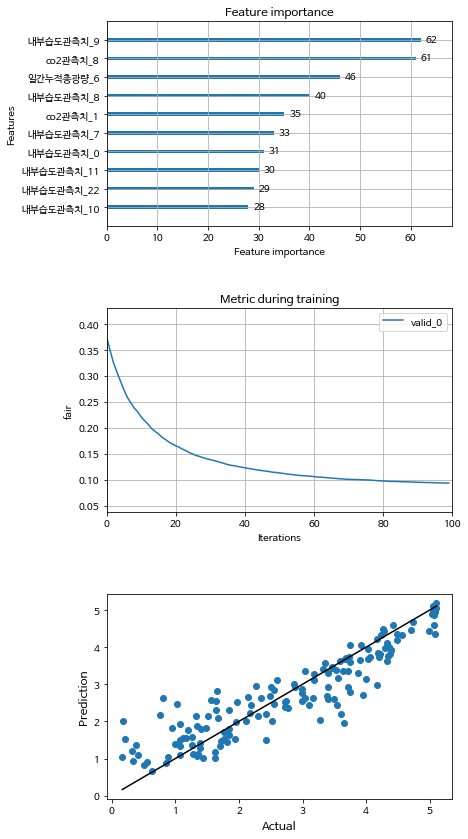

Features Importance Split & Gain...
         feature  split       gain
66      co2관측치_8     61  23.636750
55     일간누적총광량_6     46   5.437489
81    내부습도관측치_10     28   4.714756
89    내부습도관측치_11     30   4.550597
73     내부습도관측치_9     62   3.322845
97    내부습도관측치_12      7   3.264200
120   내부온도관측치_15     27   2.353035
186    co2관측치_23     13   2.325811
113   내부습도관측치_14     16   2.212610
65     내부습도관측치_8     40   1.815920
146    co2관측치_18     21   1.647366
121   내부습도관측치_15     22   1.522922
144   내부온도관측치_18     23   1.456925
10      co2관측치_1     35   1.365279
80    내부온도관측치_10     24   1.266166
52    일간누적백색광량_6     22   1.240787
199   일간누적총광량_24     20   1.148788
129   내부습도관측치_16     15   1.025195
88    내부온도관측치_11     11   0.978291
184   내부온도관측치_23     19   0.944195
2       co2관측치_0     25   0.936285
99      ec관측치_12     19   0.890255
112   내부온도관측치_14     25   0.811480
128   내부온도관측치_16     23   0.801112
137   내부습도관측치_17     11   0.798687
57     내부습도관측치_7     33   0.662999
58      co2관측치_7   

In [21]:
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


max_bin = tuning_max_bin()
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

params = {'max_bin':max_bin, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [22]:
max_bin = tuning_max_bin()
train_x, train_y = load_train()

RepNo = 5                                                                      # 품목 갯수
for rep in range(1, RepNo+1):
    print(f"Learning and Predicting for RepNo: {rep}")
    test_x, test_y = load_test(TestNo=rep)

    if (rep == 1):                                                              # 학습은 첫번째에만 하도록 한다.
        model, _, _, cv_preds = run_lgb({'max_bin':max_bin}, train_x, train_y, None, None, test_x, None)
        pred_Y = cv_preds.values
    else:
        pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

    test_y['predicted_weight_g'] = pred_Y
    test_y.columns = ['DAT','predicted_weight_g']
    test_y.set_index('DAT',inplace= True)
    test_y.to_csv(RESULTS_DIR + f'TEST_{rep:02d}.csv')

import zipfile
os.chdir(RESULTS_DIR)
submission = zipfile.ZipFile("submission.zip", 'w')
for rep in range(1, RepNo+1):
    path = f'TEST_{rep:02d}.csv'
    submission.write(path)
submission.close()
print(f'Saved {RESULTS_DIR}submission.zip')
os.chdir("..")

max_bin: 511. RMSE: 16.292
max_bin:2047. RMSE: 16.292
max_bin:4095. RMSE: 16.292
Best max_bin: 511
Learning and Predicting for RepNo: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 